### Implementación de un modelo para clasificar sujetos sanos y sujetos con COVID-19, a partir de imágines de torax de rayos X

#### Carga de librerías

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import cv2

#### Función para la carga de las imágenes en disco

In [2]:
def load_and_process_images(folder_path, label):
    images = []
    labels = []
    original_sizes = []
        
    for filename in os.listdir(folder_path):
        #Cargar imagen
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  #Leer en escala de grises
        if img is not None:
            original_sizes.append(img.shape)  #Guarda el tamaño original
            
            #Redimensiona imagen
            img_resized = cv2.resize(img, (224, 224))

            #Normaliza imagen
            img_normalized = img_resized / 255.0

            #Agrega a la lista
            images.append(img_normalized)
            labels.append(label)

    return images, labels, original_sizes

#### Muestra un conjunto de imágenes de muestra

In [3]:
def plot_images(images, labels, num_images=5):
    #Selecciona imágenes y etiquetas al azar a mostrar
    random_indices = np.random.choice(range(len(images)), num_images, replace=False)
    selected_images = [images[i] for i in random_indices]
    selected_labels = [labels[i] for i in random_indices]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'L: {label}')
        axes[i].axis('off')
    plt.show()

### Análisis exploratorio

In [4]:
#Carga las imágenes de las carpetas 'covid' y 'normal'
covid_images, covid_labels, covid_original = load_and_process_images('torax/covid/', 1)
normal_images, normal_labels, normal_original = load_and_process_images('torax/normal/', 0)

In [5]:
all_labels = np.array(covid_labels + normal_labels)

In [6]:
print('Total de imágenes con COVID: ', len(covid_images))
print('Total de imágenes sanos: ', len(normal_images))
min_size = min(covid_original)
max_size = max(covid_original)
print('Imagenes con COVID:')
print(f"Tamaño mínimo de imagen: {min_size}")
print(f"Tamaño máximo de imagen: {max_size}")
min_size = min(normal_original)
max_size = max(normal_original)
print('Imagenes Sanas:')
print(f"Tamaño mínimo de imagen: {min_size}")
print(f"Tamaño máximo de imagen: {max_size}")

Total de imágenes con COVID:  69
Total de imágenes sanos:  25
Imagenes con COVID:
Tamaño mínimo de imagen: (237, 328)
Tamaño máximo de imagen: (4095, 3342)
Imagenes Sanas:
Tamaño mínimo de imagen: (893, 1284)
Tamaño máximo de imagen: (2121, 2400)


#### Función para balancear el conjunto de imágenes

In [7]:
def augment_images(image_array, label, augment_size):
    #Inicializa ImageDataGenerator con opciones de aumento
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    #Valida las dimensiones
    if len(image_array.shape) == 3:
        image_array = np.expand_dims(image_array, axis=3)
        
    #Determina el número de imágenes a generar
    diff = augment_size - len(image_array)
    if diff <= 0:
        return image_array, np.full(len(image_array), label)

    #Genera nuevas imágenes
    i = 0
    augmented_images = []
    augmented_labels = []
    for x, _ in datagen.flow(image_array, np.zeros(len(image_array)), batch_size=1, seed=42):
        augmented_images.append(x[0])
        augmented_labels.append(label)
        i += 1
        if i >= diff:
            break

    augmented_images = np.concatenate((image_array, np.array(augmented_images)))
    augmented_labels = np.concatenate((np.full(len(image_array), label), np.array(augmented_labels)))

    return augmented_images, augmented_labels

#### Se generan las nuevas imágenes para equilibrar el conjunto

In [8]:
augmented_covid_images, augmented_covid_labels = augment_images(np.array(covid_images), 1, 150)
augmented_normal_images, augmented_normal_labels = augment_images(np.array(normal_images), 0, 150)

In [9]:
print('Total de imágenes con COVID: ', len(augmented_covid_images))
print('Total de imágenes sanos: ', len(augmented_normal_images))

all_labels = np.concatenate((augmented_covid_labels, augmented_normal_labels))

Total de imágenes con COVID:  150
Total de imágenes sanos:  150


#### Se combinan los dos conjuntos de imágenes

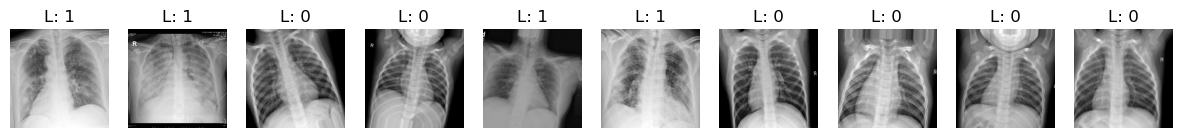

In [10]:
#Combina datos y etiquetas
all_images = np.concatenate((augmented_covid_images,augmented_normal_images))
all_labels = np.concatenate((augmented_covid_labels, augmented_normal_labels))

# Muestra imágenes para validar
plot_images(all_images, all_labels, num_images=10)

### Preparación del modelo

#### Se preparan los conjuntos de datos de entrenamiento, validación y test

In [11]:
#Define los conjuntos de entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42)

In [12]:
#Define el conjunto de validación
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

### Modelo

    Se implementa un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes.
    
    Se utilizan capas Conv2D, Maxpooling2D, Flatten, Dense, Dropout
    Se agrega una regularización L2 con factor de 1e-4
    El modelo es secuencial
    

In [13]:
l2_regularizer = regularizers.L2(l2=1e-8)

#Crea el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    Flatten(),
    
    Dense(128, kernel_regularizer= l2_regularizer, activation='relu'),
    Dropout(0.6),
    
    Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Pro


### Compilación

In [14]:
#Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

### Entrenamiento

In [15]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=32
)

Epoch 1/20


2023-12-20 21:38:50.028510: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x111x111x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x54x54x64xi1>'
loc("mps_select"("(mpsFileLoc)

1/6 [====>.........................] - ETA: 3s - loss: 0.9120 - accuracy: 0.4375

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

5/6 [========================>.....] - ETA: 0s - loss: 1.3244 - accuracy: 0.4938

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<20x111x111x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<20x54x54x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerfo

6/6 [==============================] - ETA: 0s - loss: 1.2484 - accuracy: 0.5167

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<20x26x26x128xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<20x54x54x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerfor

6/6 [==============================] - 2s 193ms/step - loss: 1.2484 - accuracy: 0.5167 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 2/20


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

6/6 [==============================] - 1s 93ms/step - loss: 0.6987 - accuracy: 0.5278 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 3/20
6/6 [==============================] - 1s 93ms/step - loss: 0.6914 - accuracy: 0.5111 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 4/20
6/6 [==============================] - 1s 93ms/step - loss: 0.6855 - accuracy: 0.6167 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 5/20
6/6 [==============================] - 1s 93ms/step - loss: 0.6607 - accuracy: 0.6000 - val_loss: 0.6859 - val_accuracy: 0.7833
Epoch 6/20
6/6 [==============================] - 1s 93ms/step - loss: 0.6762 - accuracy: 0.5889 - val_loss: 0.6804 - val_accuracy: 0.9000
Epoch 7/20
6/6 [==============================] - 1s 93ms/step - loss: 0.5629 - accuracy: 0.7056 - val_loss: 0.6472 - val_accuracy: 0.9333
Epoch 8/20
6/6 [==============================] - 1s 92ms/step - loss: 0.4340 - accuracy: 0.8111 - val_loss: 0.6141 - val_accuracy: 0.8833
Epoch 9/20
6/6 [======================

### Análisis de resultados de entrenamiento

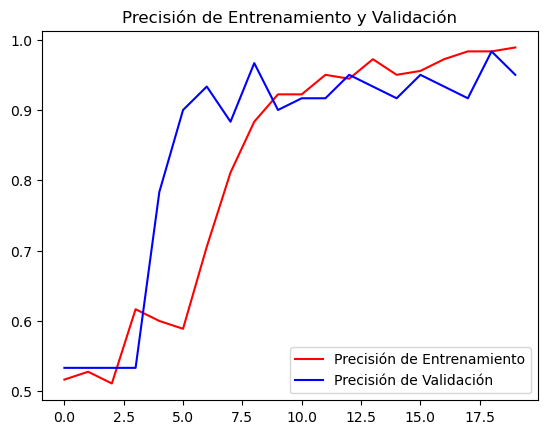

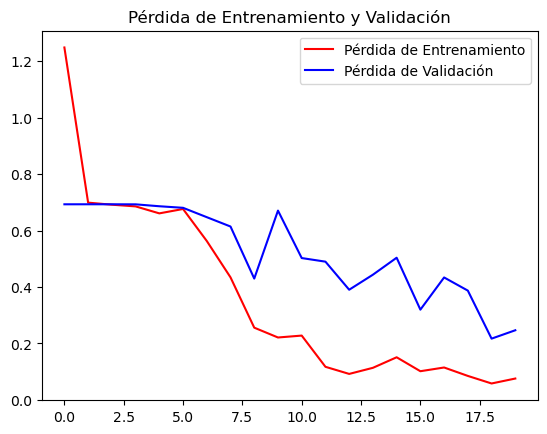

In [16]:
#Datos de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  

#Gráfica de precisión
plt.plot(epochs, acc, 'r', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend(loc=0)
plt.figure()

#Gráfica de pérdida
plt.plot(epochs, loss, 'r', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend(loc=0)
plt.show()

### Predicciones con el conjunto de datos de test

In [17]:
#Predicciones con conjunto de prueba
predictions_prob = model.predict(test_images)
predictions = [1 if prob > 0.5 else 0 for prob in predictions_prob]

2/2 [==============================] - 0s 53ms/step


### Resultados de test en matriz de confusión

In [18]:
conf_matrix = confusion_matrix(test_labels, predictions)

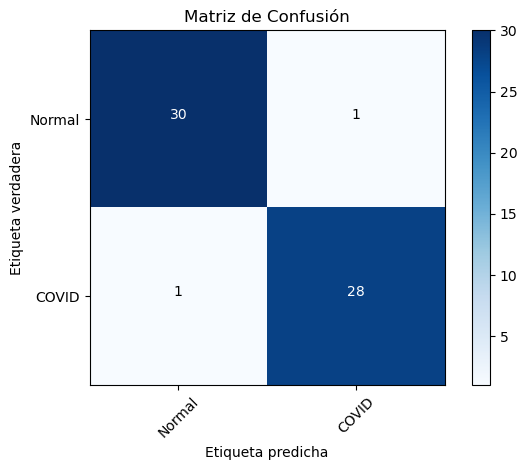

In [19]:
#Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

class_names = ['Normal', 'COVID']

plot_confusion_matrix(conf_matrix, classes=class_names)

In [20]:
accuracy = accuracy_score(test_labels, predictions)
print(f'Precisión (Accuracy): {accuracy:.2f}')
precision = precision_score(test_labels, predictions)
print(f'Precisión (Precision): {precision:.2f}')
recall = recall_score(test_labels, predictions)
print(f'Sensibilidad (Recall): {recall:.2f}')
f1 = f1_score(test_labels, predictions)
print(f'Puntuación F1 (F1 Score): {f1:.2f}')
roc_auc = roc_auc_score(test_labels, predictions_prob)
print(f'Área bajo la curva ROC (ROC-AUC): {roc_auc:.2f}')


Precisión (Accuracy): 0.97
Precisión (Precision): 0.97
Sensibilidad (Recall): 0.97
Puntuación F1 (F1 Score): 0.97
Área bajo la curva ROC (ROC-AUC): 0.99
